# GroupBy E-commerce Recommender System with Implicit data
> Recommendation system using collaborative filtering for implicit data on e-commerce customer journey. Capstone project for Machine Learning Engineer Bootcamp at FourthBrain. It is an industry sponsored project from GroupBy, an e-commerce start up that aims to create highly converting and relevant site experience to maximize revenue through e-commerce channels. Also benchmarking movielens and cosmetics datasets.

- toc: true
- badges: true
- comments: true
- categories: [Cosmetics, Retail, ECommerce, LightFM, Implicit, Flask, FrontEnd, API, Movie, ElasticBeanStalk]
- author: "<a href='https://github.com/tjeng/recommendation'>Janice Tjeng</a>"
- image:

## Introduction

Industry sponsored project from GroupBy, an e-commerce start up that aims to create highly converting and relevant site experience to maximize revenue through e-commerce channels

Online shopping offers millions of items for users to choose from, but with limited attention span and limited real estate space, it becomes necessary to handle information overload. Recommendation system can solve the problem by ranking and recommending top items based on users' preference. It is also reported that 35% of Amazon’s revenue comes from its recommendation engine.

## Setup

In [ ]:
!pip install lightfm

In [1]:
import json
import pickle
import numpy as np
import pandas as pd
from scipy import sparse
from datetime import datetime
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
from scipy.sparse import csr_matrix, coo_matrix
from sklearn.metrics.pairwise import cosine_similarity

# lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k

## Data
GroupBy has provided its internal data (raw data not shared) that contains customer product interaction data where there is information on the interaction with an item (search, view, add to cart, or purchase), as well as product brand, and price collected over 1 day.

A user-item matrix is created that contains 44,588 users and 17,480 products, with 1M interactions. The interaction is a binary 1 or 0 that indicates whether the user purchases the item or not. This is a form of implicit feedback where user's preference for an item is indirectly inferred from behavior patterns versus explicit feedback where the user gives a rating of the product.

The dataset is randomly split based on interactions into train and test sets, 80% and 20% respectively. All users and items are in train and test sets but 20% of the interactions are masked from the training set. There might not be any interaction for a user in the train set and the items recommended is compared to the items purchased in the test set to evaluate model performance.

In [ ]:
!mkdir data
!cd data && wget https://github.com/sparsh-ai/recommendation/raw/main/recdeployment/recapp/data/interactions.npz
!cd data && wget https://github.com/sparsh-ai/recommendation/raw/main/recdeployment/recapp/data/item_dictionary.json
!cd data && wget https://github.com/sparsh-ai/recommendation/raw/main/recdeployment/recapp/data/item_mapping.json
!cd data && wget https://github.com/sparsh-ai/recommendation/raw/main/recdeployment/recapp/data/user_mapping.json

## Data loading

In [ ]:
data = [json.loads(line) for line in open('raw_data.json', 'r')]
df = pd.json_normalize(data)
df.customerVisitorId.nunique()

44876

In [ ]:
df.columns

Index(['customerId', 'customerArea', 'customerVisitorId', 'customerLoginId',
       'customerSessionId', 'sessionStartTime', 'sessionEndTime',
       'customerSessionNumber', 'hits', 'totals.timeOnSite', 'totals.events',
       'totals.newSession', 'totals.bounce', 'totals.totalSearches',
       'totals.totalNavigations', 'totals.totalRefinements',
       'totals.totalViewProducts', 'totals.totalViewProductRevenue',
       'totals.totalNullSearches', 'totals.uniqueViewProducts',
       'trafficSource.gbiFlag', 'trafficSource.deviceCategory',
       'trafficSource.device', 'trafficSource.browser', 'trafficSource.os',
       'trafficSource.userAgent', 'trafficSource.language',
       'trafficSource.page', 'trafficSource.city', 'trafficSource.region',
       'trafficSource.country', 'trafficSource.campaign',
       'trafficSource.source', 'trafficSource.medium', 'trafficSource.content',
       'totals.totalAddToCarts', 'totals.totalAddToCartQty',
       'totals.totalAddToCartRevenue', 'to

## Preprocessing

In [ ]:
cols = ['customerVisitorId', 'customerSessionId','sessionStartTime', 'sessionEndTime', 'customerSessionNumber']
hits = pd.json_normalize(data, record_path=['hits', 'product'], meta=cols)
hits[hits.customerVisitorId=='cki8pfl1y000139ebdeezn6pn']

,sku,ID,name,price,collection,attributedSearches,quantity,listLocation,listPosition,customerVisitorId,customerSessionId,sessionStartTime,sessionEndTime,customerSessionNumber
1474200,SWA051,SWA051,dr. stephen langer's ultimate 16 strain probio...,14.79,Swanson Probiotics,[],NaN,NaN,NaN,cki8pfl1y000139ebdeezn6pn,cki8pfl1y000139ebdeezn6pn1606894616,2020-12-02 07:36:56.522423 UTC,2020-12-02 07:40:45.201722 UTC,1
1474201,SWA051,SWA051,dr. stephen langer's ultimate 16 strain probio...,14.79,default,[],NaN,NaN,NaN,cki8pfl1y000139ebdeezn6pn,cki8pfl1y000139ebdeezn6pn1606894616,2020-12-02 07:36:56.522423 UTC,2020-12-02 07:40:45.201722 UTC,1
1474202,SWA051,SWA051,dr. stephen langer's ultimate 16 strain probio...,14.79,default,[],3,NaN,NaN,cki8pfl1y000139ebdeezn6pn,cki8pfl1y000139ebdeezn6pn1606894616,2020-12-02 07:36:56.522423 UTC,2020-12-02 07:40:45.201722 UTC,1
1474203,SWA051,SWA051,3.2 billion cfu 60 veg drcaps,14.79,Swanson Probiotics,[],3,NaN,NaN,cki8pfl1y000139ebdeezn6pn,cki8pfl1y000139ebdeezn6pn1606894616,2020-12-02 07:36:56.522423 UTC,2020-12-02 07:40:45.201722 UTC,1


In [ ]:
hits.collection.value_counts()

swansonhealthproduction    1573529
default                      36134
Swanson Premium              17705
Swanson Ultra                11953
NOW Foods                     6493
                            ...   
Atkins                           1
Dr. Linus Pauling                1
EFX Sports                       1
Aaraam                           1
Red Ace                          1
Name: collection, Length: 905, dtype: int64

In [ ]:
all_cols = df.columns[df.columns.str.contains('totals')].tolist() + cols
df_merged = df[all_cols].merge(hits, how='left', on=cols)
df_merged[df_merged.customerVisitorId=='cki8pfl1y000139ebdeezn6pn'][['ID', 'name', 'price', 'totals.totalOrders', 'totals.totalOrderQty', 'customerSessionId', 'customerSessionNumber', 'totals.uniqueOrders', 'totals.totalViewProducts', 'totals.totalAddToCarts']]

,ID,name,price,totals.totalOrders,totals.totalOrderQty,customerSessionId,customerSessionNumber,totals.uniqueOrders,totals.totalViewProducts,totals.totalAddToCarts
1474537,SWA051,dr. stephen langer's ultimate 16 strain probio...,14.79,1,3,cki8pfl1y000139ebdeezn6pn1606894616,1,1,2,1
1474538,SWA051,dr. stephen langer's ultimate 16 strain probio...,14.79,1,3,cki8pfl1y000139ebdeezn6pn1606894616,1,1,2,1
1474539,SWA051,dr. stephen langer's ultimate 16 strain probio...,14.79,1,3,cki8pfl1y000139ebdeezn6pn1606894616,1,1,2,1
1474540,SWA051,3.2 billion cfu 60 veg drcaps,14.79,1,3,cki8pfl1y000139ebdeezn6pn1606894616,1,1,2,1


(array([1.23361e+05, 1.46570e+04, 2.08600e+03, 4.64000e+02, 9.60000e+01,
        4.90000e+01, 5.00000e+00, 1.00000e+00, 8.00000e+00, 9.00000e+00]),
 array([  0.66 ,  23.914,  47.168,  70.422,  93.676, 116.93 , 140.184,
        163.438, 186.692, 209.946, 233.2  ]),
 <a list of 10 Patch objects>)

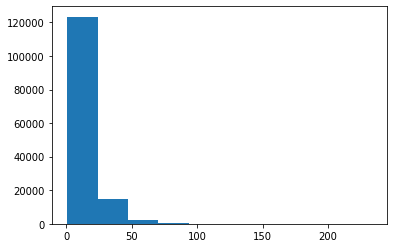

In [ ]:
plt.hist(hits.price)

**Filter price**

In [ ]:
df_merged2 = df_merged[(df_merged.price>=11) & (df_merged.price<=24)] 
md = np.median(hits[~hits.price.isnull()].price)
len(hits['price'])

1714266

In [ ]:
df_rm_dup = df_merged.drop_duplicates(['customerVisitorId', 'ID', 'price', 'customerSessionId'])
df_rm_dup.collection.value_counts(normalize=True)

swansonhealthproduction    9.164339e-01
Swanson Premium            1.230345e-02
Swanson Ultra              8.300530e-03
default                    6.516277e-03
NOW Foods                  4.755789e-03
                               ...     
Ostrim                     9.505875e-07
Inholtra                   9.505875e-07
Maximum International      9.505875e-07
Baie Run                   9.505875e-07
Superfood For Skin         9.505875e-07
Name: collection, Length: 905, dtype: float64

In [ ]:
df_rm_dup[['ID', 'price', 'collection', 'name']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1052318 entries, 0 to 1714602
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   ID          1051981 non-null  object 
 1   price       87909 non-null    float64
 2   collection  1051981 non-null  object 
 3   name        87910 non-null    object 
dtypes: float64(1), object(3)
memory usage: 40.1+ MB


In [ ]:
df_rm_dup[df_rm_dup.name.isnull()].ID

2441          NaN
2442       CSN193
2443          NaN
2444       SWF116
2445       SWF068
            ...  
1714334    CRL396
1714335    SW1453
1714336    SWU248
1714337    NWF270
1714338    NWF139
Name: ID, Length: 964408, dtype: object

**Create dictionary of item ID, name, price, collection**

In [ ]:
mult_collection = df_rm_dup.groupby('ID')['collection'].nunique().sort_values(ascending=False).reset_index()
mult_collection

,ID,collection
0,SW923,7
1,SW1371,6
2,SW1113,6
3,SWA051,6
4,SW1782,6
...,...,...
17475,KND004,1
17476,SN135,1
17477,NWF1044,1
17478,SN132,1


In [ ]:
hits[hits.ID=='SW923'].collection.unique()

array(['swansonhealthproduction', 'Swanson Premium', 'default', 'Kal',
       'Life Extension', 'Swanson Ultra', 'Swanson Superior Herbs'],
      dtype=object)

In [ ]:
dic = {}
for i in range(len(df_rm_dup)):
    prod = df_rm_dup.iloc[i]
    if prod.ID not in dic.keys() and str(prod.sku) != 'nan':
        dic[prod.ID] = {}
        dic[prod.ID]['name'] = prod['name']
        dic[prod.ID]['collection'] = prod.collection
        dic[prod.ID]['price'] = prod.price

In [ ]:
df_rm_dup['totals.totalOrderQty'] = df_rm_dup['totals.totalOrderQty'].fillna(0)
df_rm_dup['totals.totalOrderQty'] = df_rm_dup['totals.totalOrderQty'].astype(int)
num_purchase = df_rm_dup.groupby(['customerVisitorId', 'ID']).agg({'totals.totalOrderQty':'sum', 'price':'mean', 'customerSessionId':'nunique', 'collection':'first'})
num_purchase = num_purchase.reset_index().rename(columns={"totals.totalOrderQty":"numPurchase"})
num_purchase['Purchase'] = num_purchase.numPurchase.apply(lambda x: 1 if x!=0 else 0)

In [ ]:
cust_collection = num_purchase.groupby("customerVisitorId")['collection'].apply(list).reset_index()
cust_collection['contains_swansonhealth'] = cust_collection['collection'].apply(lambda x: 'swansonhealthproduction' not in x)
num_purchase['price'] = np.where(num_purchase.price.isnull(), md, num_purchase.price)
num_purchase['price_category'] = np.where(num_purchase.price>=94, 'very expensive', np.where((num_purchase.price>= 48) & (num_purchase.price<94), 'expensive', np.where((num_purchase.price>= 24) & (num_purchase.price<48), 'medium', 'cheap')))
num_purchase.head()

,customerVisitorId,ID,numPurchase,price,customerSessionId,collection,Purchase
0,cjo06cah000013ea3jqwotb8g,AAM013,0,NaN,2,swansonhealthproduction,0
1,cjo06cah000013ea3jqwotb8g,AAM016,0,NaN,2,swansonhealthproduction,0
2,cjo06cah000013ea3jqwotb8g,AAM019,0,NaN,2,swansonhealthproduction,0
3,cjo06cah000013ea3jqwotb8g,ARG010,0,NaN,2,swansonhealthproduction,0
4,cjo06cah000013ea3jqwotb8g,DB088,0,NaN,2,swansonhealthproduction,0


**Analysis of product price category and number of sessions with regards to purchase**

In [ ]:
num_purchase[num_purchase.Purchase==1].groupby('price_category')['customerSessionId'].mean()

price_category
cheap             1.019692
expensive         1.066176
medium            1.090868
very expensive    1.000000
Name: customerSessionId, dtype: float64

Text(0.5, 1.0, 'Groupby Data Filter by Category')

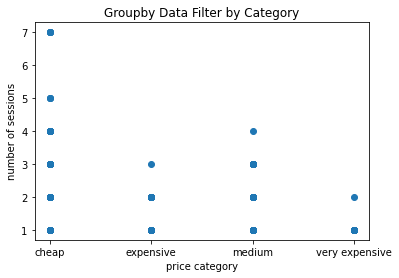

In [ ]:
plt.scatter(num_purchase[(num_purchase.collection=='swansonhealthproduction')].price_category, num_purchase[num_purchase.collection=='swansonhealthproduction'].customerSessionId)
plt.xlabel('price category')
plt.ylabel('number of sessions')
plt.title('Groupby Data Filter by Category')

In [ ]:
num_purchase[(num_purchase.Purchase==1) & (num_purchase.price>=11) & (num_purchase.price<=24)].ID.nunique()

2649

In [ ]:
num_purchase.groupby('price_category')['ID'].count()

price_category
cheap             986914
expensive           1550
medium              8772
very expensive       128
Name: ID, dtype: int64

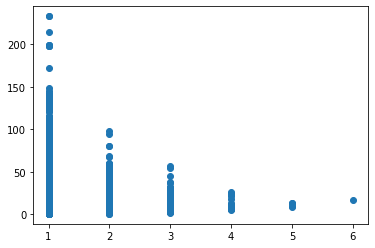

In [ ]:
plt.scatter(num_purchase[num_purchase.Purchase==0].customerSessionId, num_purchase[num_purchase.Purchase==0].price)

**Splitting data into train and test sets**

In [2]:
def random_split(data, user_id, item_id, metric, item_features=None):
  dataset = Dataset()
  dataset.fit(data[user_id], data[item_id], item_features=item_features)
  num_users, num_items = dataset.interactions_shape()
  print('Num users: {}, num_items {}.'.format(num_users, num_items))
  dataset.fit_partial(users=data[user_id], 
                     items=data[item_id],
                     item_features=item_features)
  fe = data.to_dict(orient='records')
  (interactions, weights) = dataset.build_interactions((x[user_id], x[item_id], x[metric]) for x in fe)
  (train, test) = random_train_test_split(interactions=interactions, test_percentage=0.2, random_state=2)
  print('Num values: {}'.format(len(interactions.data)))  
  return dataset, train, test, interactions

In [ ]:
def calc_sparsity(data, user_id, item_id, metric):
    item_user_matrix = pd.DataFrame(data.pivot_table(index=[user_id], columns=item_id, values=metric))
    item_user_matrix.fillna(0,inplace=True)
    print('sparsity in data:',(1.0 - (np.count_nonzero(item_user_matrix) / float(item_user_matrix.size))))

In [ ]:
dataset, train_g, test_g, interactions = random_split(num_purchase, 'customerVisitorId', 'ID', 'Purchase')

Num users: 44599, num_items 17480.
Num values: 997364


In [ ]:
train_g.shape

(44599, 17480)

In [ ]:
test_g.shape

(44599, 17480)

**Create dictionary to map user and item index**

In [ ]:
user_id_map, user_features, item_id_map, item_features = dataset.mapping()

In [ ]:
item_id_map_rev = {int(v):k for k,v in item_id_map.items()}

In [ ]:
user_id_map_rev = {int(v):k for k,v in user_id_map.items()}

In [ ]:
train_g

<44599x17480 sparse matrix of type '<class 'numpy.int32'>'
	with 797891 stored elements in COOrdinate format>

In [ ]:
test_g

<44599x17480 sparse matrix of type '<class 'numpy.int32'>'
	with 199473 stored elements in COOrdinate format>

In [ ]:
calc_sparsity(num_purchase, 'customerVisitorId', 'ID', 'Purchase')

sparsity in data: 0.999594617954051


## Algorithm

Collaborative Filtering Matrix Factorization (MF) is used where an mxn matrix (m: number of users, n: number of items) is decomposed into mxk user factor and kxn item factor. The factors are multiplied to get the score for an item for a particular user. The figure below illustrates the matrix factorization. k represents the number of latent factors, or dimensions.

LightFM package link is used to perform MF. A common loss function for MF is mean square error where the gradient updates to minimize the difference between actual and predicted scores. Such technique is common for explicit feedback data. For this dataset that consists of implicit feedback, ranking of items, where a purchased item ranks higher than a non-purchased item, are of interest. Hence, weighted average ranking pairwise (WARP) loss link is used as the loss function. For each user, there is a pair of positive and negative items. A positive item indicates that the user has purchased the item and a negative item indicates that the user has not purchased the item. The loss function only updates when the rank of a negative item exceeds that of a positive item. This approximates a form of active learning that yields a more informative gradient update, where the model samples the number of negative items Q times until the rank of a negative item exceeds that of a positive item. The loss function is described below.

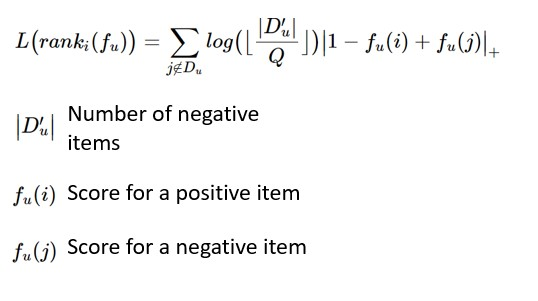

## LightFM model training

In [8]:
def model_fit_eval(loss, train, test, n_components, k_items, k=5, n=10, item_features=None):
  model = LightFM(no_components=n_components, loss=loss, item_alpha=1e-6, random_state=2, k=k, n=n)
  %time model.fit(train, epochs=10, num_threads=3, item_features=item_features)
  test_auc = auc_score(model, test, train_interactions=train, num_threads=3, item_features=item_features).mean()
  print('Collaborative filtering test AUC: %s' % test_auc)
  prec = precision_at_k(model, test, train_interactions=train, num_threads=3, k=k_items, item_features=item_features).mean()
  print('Collaborative filtering test precision: %s' % prec)
  recal = recall_at_k(model, test, train_interactions=train, num_threads=3, k=k_items, item_features=item_features).mean()
  print('Collaborative filtering test recall: %s' % recal)
  return model

In [ ]:
model_g = model_fit_eval('warp', train_g, test_g, 128, 5)

CPU times: user 24.6 s, sys: 19.5 ms, total: 24.6 s
Wall time: 8.82 s
Collaborative filtering test AUC: 0.8918844
Collaborative filtering test precision: 0.38604438
Collaborative filtering test recall: 0.29490969857731075


## Results

The important parameter to tune is k, the number of dimensions. The table below shows model performance with different values of k:

| K | Metric | Value |
| - | -:| ---:|
| 32 | AUC | 0.87 |
| 64 | AUC | 0.88 |
| 128 | AUC | 0.89 |
| 192 | AUC | 0.89 |
| 32 | Precision@5 | 0.38 |
| 64 | Precision@5 | 0.32 |
| 128 | Precision@5 | 0.40 |
| 192 | Precision@5 | 0.41 |
| 32 | Recall@5 | 0.22 |
| 64 | Recall@5 | 0.27 |
| 128 | Recall@5 | 0.30 |
| 192 | Recall@5 | 0.31 |

- 128 dimension is selected as model performance starts to plateau.
- AUC measures the probability that a randomly chosen positive example has a higher score than a randomly chosen negative example.
- Precision@5 measures the fraction of items bought out of the 5 recommended items
- Recall@5 measures the number of items bought in the top 5 recommendations divided by the total number of items bought


## Recommending items

In [ ]:
def similar_recommendation(model, interactions, user_id, user_dikt, 
                               item_dikt, item_dikt_rev, product_dict, threshold = 0, number_rec_items = 5):

    #Function to produce user recommendations

    n_items = len(item_dikt.keys())
    user_x = user_dikt[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items)))
    scores.index = item_dikt.keys()
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    user_item_scores = interactions.toarray()[user_x]
    item_index = np.where(user_item_scores>0)[0]
    known_items = pd.DataFrame({ 'items': [item_dikt_rev[i] for i in item_index], 'scores':user_item_scores[item_index]}).sort_values('scores', ascending=False)
    
    scores = [x for x in scores if x not in known_items['items'].values]
    score_list = scores[0:number_rec_items]

    print("Items that were liked by the User:")
    counter = 1
    for i in range(len(known_items)):
        item = known_items.loc[i]['items']
        if str(product_dict[item]['name']) != 'nan':
            print(str(counter) + '- ' + str(product_dict[item]['name']) + ', ' + str(product_dict[item]['price']) + ', ' + product_dict[item]['collection'])
        else:
            print(str(counter) + '- ' + str(product_dict[item]['collection']))
        counter+=1

    print("\n Recommended Items:")
    counter = 1
    for i in score_list:
        if str(product_dict[i]['name']) != 'nan':
            print(str(counter) + '- ' + product_dict[i]['name'] + ', ' + str(product_dict[i]['price']) + ', ' + product_dict[i]["collection"]) 
        else:
            print(str(counter) + '- ' + product_dict[i]['collection'])
        counter+=1
#     return score_list

In [ ]:
similar_recommendation(model, interactions, 'cjo06esrd00013gblo1n3haw7', user_id_map, 
                               item_id_map, item_id_map_rev, product_dic, threshold = 0, number_rec_items = 5)

Items that were liked by the User:
1- zinc picolinate - body preferred form, 2.99, Swanson Premium

 Recommended Items:
1- zinc citrate, 2.84, Swanson Premium
2- vitamin c with rose hips, 11.49, Swanson Premium
3- full spectrum saw palmetto, 9.49, Swanson Premium
4- full spectrum ashwagandha, 5.79, Swanson Premium
5- omega-3 fish oil - lemon flavor, 6.99, Swanson Premium


In [ ]:
similar_recommendation(model, interactions, 'cjo09x89u00013gb80mn9xb57', user_id_map, 
                               item_id_map, item_id_map_rev, product_dic, threshold = 0, number_rec_items = 5)

Items that were liked by the User:
1- long-lasting deodorant stick - refreshing lavender, 5.89, NOW Foods

 Recommended Items:
1- 12 oz pwdr, 19.78, Swanson Ultra
2- mct oil - 100% pure pharmaceutical grade, 7.98, Swanson Ultra
3- acti-joint plus with krill oil, 13.18, Swanson Ultra
4- vitamin d-3 & k-2, 5.99, NOW Foods
5- chlorella complex, 17.99, Swanson Kyoto Brand


In [ ]:
similar_recommendation(model_g, 'cjo6507qf00013ac37tbxxu8z', user_id_map, 
                               item_id_map, item_id_map_rev, dic, threshold = 0, number_rec_items = 5)

Items that were liked by the User:
1- 400 iu (10 mcg) 250 sgels, 3.99, Swanson Premium
2- longjax eurycoma longifolia jack extract, 18.99, Swanson Passion
3- high immunoglobulin colostrum, 18.39, default

 Recommended Items:
1- vitamin d3 - highest potency, 10.99, default
2- vitamin d3 - high potency, 4.79, default
3- super stress vitamin b-complex with vitamin c, 15.49, Swanson Premium
4- coq10 - high potency, 8.99, Swanson Ultra
5- zinc picolinate - body preferred form, 2.99, Swanson Premium


In [ ]:
def item_emdedding_distance_matrix(model, item_dikt):

    # Function to create item-item distance embedding matrix
    df_item_norm_sparse = csr_matrix(model.item_embeddings)
    similarities = cosine_similarity(df_item_norm_sparse)
    item_emdedding_distance_matrix = pd.DataFrame(similarities)
    item_emdedding_distance_matrix.columns = item_dikt.keys()
    item_emdedding_distance_matrix.index = item_dikt.keys()
    return item_emdedding_distance_matrix

def also_bought_recommendation(item_emdedding_distance_matrix, item_id, 
                             product_dict, n_items = 5):

    # Function to create item-item recommendation
    recommended_items = list(pd.Series(item_emdedding_distance_matrix.loc[item_id,:]. \
                                  sort_values(ascending = False).head(n_items+1). \
                                  index[1:n_items+1]))
    
    print("Item of interest:")
    print(str(product_dict[item_id]['name']) + ', ' + str(product_dict[item_id]['price']) + ', ' + product_dict[item_id]['collection'])
    print("\n")
    print("Items that are frequently bought together:")
    counter = 1
    for i in recommended_items:
        if i in product_dict.keys():
            print(str(counter) + '- ' + str(product_dict[i]['name']) + ', ' + str(product_dict[i]['price']) + ', ' + product_dict[i]['collection'])
        else:
            print(str(counter) + '- ' + 'swansonhealthproduct')
        counter+=1
    #return recommended_items

In [ ]:
item_dist = item_emdedding_distance_matrix(model, item_id_map)

In [ ]:
also_bought_recommendation(item_dist, 'SW1113', dic)

Item of interest:
zinc picolinate - body preferred form, 2.99, Swanson Premium


Items that are frequently bought together:
1- zinc citrate, 2.84, Swanson Premium
2- vitamin d3 - high potency, 4.79, default
3- full spectrum saw palmetto, 9.49, Swanson Premium
4- vitamin c with rose hips, 11.49, Swanson Premium
5- triple magnesium complex, 11.99, Swanson Premium


In [ ]:
also_bought_recommendation(item_dist, 'SWD015', dic)

Item of interest:
fat burner - 2 pack, 12.49, Swanson Best Weight-Control Formulas


Items that are frequently bought together:
1- fat burner, 7.99, Swanson Best Weight-Control Formulas
2- swansonhealthproduct
3- super fat burners extreme, 11.61, Natural Balance
4- swansonhealthproduct
5- full spectrum pterocarpus marsupium, 10.79, Swanson Premium


## API

For a demo, the model is served as an API using Flask. The Flask app is deployed on AWS Elastic Beanstalk, with the following url, http://recapp.eba-u3jbujfw.us-east-1.elasticbeanstalk.com/. To use the app, enter a user id. If the user id exists in the existing database of users, top 5 items will be recommended based on the user's purchasing history. If the user is a new user, the top 5 most popular items (purchased by most users) will be displayed instead. Due to proprietary information, user id to test will not be provided.

> Note: This EBS is currently active but might not work in future. So we included screenshots along with backend HTML for reference.

In [2]:
%%writefile index.html
<!DOCTYPE html>
<html >
<head>
  <meta charset="UTF-8">
  <title>Product Recommendation</title>
  <link href='https://fonts.googleapis.com/css?family=Pacifico' rel='stylesheet' type='text/css'>
<link href='https://fonts.googleapis.com/css?family=Arimo' rel='stylesheet' type='text/css'>
<link href='https://fonts.googleapis.com/css?family=Hind:300' rel='stylesheet' type='text/css'>
<link href='https://fonts.googleapis.com/css?family=Open+Sans+Condensed:300' rel='stylesheet' type='text/css'>
<link rel="stylesheet" href="{{ url_for('static', filename='css/style.css') }}">
</head>
<body>
 <div class="login">
	<h1> Enter a User Id</h1>
     <!-- Main Input For Receiving Query to our ML -->
    <form action="{{ url_for('recommend')}}"method="post">
    	<input type="text" name="userid" placeholder="User Id"/>
        <button type="submit" class="btn">Recommend</button>
    </form>
   <br>
   <br>
 </div>
</body>
</html>

Writing index.html


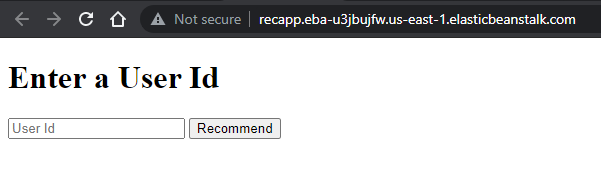

In [3]:
%%writefile recommendation.html
<!DOCTYPE html>
<html >
<head>
  <meta charset="UTF-8">
  <title>Recommending top 5 items: </title>
  <link href='https://fonts.googleapis.com/css?family=Pacifico' rel='stylesheet' type='text/css'>
<link href='https://fonts.googleapis.com/css?family=Arimo' rel='stylesheet' type='text/css'>
<link href='https://fonts.googleapis.com/css?family=Hind:300' rel='stylesheet' type='text/css'>
<link href='https://fonts.googleapis.com/css?family=Open+Sans+Condensed:300' rel='stylesheet' type='text/css'>
<link rel="stylesheet" href="{{ url_for('static', filename='css/style.css') }}">
</head>
<body>
 <div style="background-color:white;">
	<h2>Items purchased:</h2>
        {% for answ in items%}
                <p style="text-align: left; font-family: normal; font-size: 
 16px;"> {{ answ  }} </p>
           {% endfor %}
	<h2>Items recommended:</h2>
        {% for answ in rec_items%}
                <p style="text-align: left; font-family: normal; font-size: 
 16px;"> {{ answ  }} </p>
           {% endfor %}  
 </div>
</body>
</html>

Writing recommendation.html


In [4]:
%%writefile topitems.html
<!DOCTYPE html>
<html >
<head>
  <meta charset="UTF-8">
  <title>Recommending top 5 items: </title>
  <link href='https://fonts.googleapis.com/css?family=Pacifico' rel='stylesheet' type='text/css'>
<link href='https://fonts.googleapis.com/css?family=Arimo' rel='stylesheet' type='text/css'>
<link href='https://fonts.googleapis.com/css?family=Hind:300' rel='stylesheet' type='text/css'>
<link href='https://fonts.googleapis.com/css?family=Open+Sans+Condensed:300' rel='stylesheet' type='text/css'>
<link rel="stylesheet" href="{{ url_for('static', filename='css/style.css') }}">
</head>
<body>
 <div style="background-color:white;">
	<h2>Items recommended:</h2>
        {% for answ in rec_items%}
                <p style="text-align: left; font-family: normal; font-size: 
 16px;"> {{ answ  }} </p>
           {% endfor %}  
 </div>
</body>
</html>

Writing topitems.html


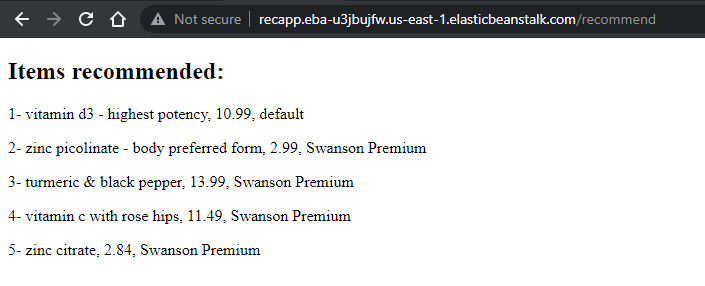

### Recommender app

In [ ]:
class Recommendation:
    def __init__(self):
        with open("user_mapping.json", "r") as uf:
            self.user_dic = json.load(uf)
        with open("item_mapping.json") as imf:
            self.item_dic = json.load(imf)
        with open("item_dictionary.json") as pf:
            self.product_dic = json.load(pf)
        with open("./recapp/static/model/recommender_model_alldata.pkl", 'rb') as f:
            self.model = pickle.load(f)
        self.interactions = sparse.load_npz("interactions.npz")
        self.item_rev_dic = {v:k for k,v in self.item_dic.items()}

    def similar_recommendation(self, user_id, threshold = 0, number_rec_items = 5):
        #Function to produce user recommendations
        n_items = len(self.item_dic.keys())
        user_x = self.user_dic[user_id]
        scores = pd.Series(self.model.predict(user_x,np.arange(n_items)))
        scores.index = self.item_dic.keys()
        scores = list(pd.Series(scores.sort_values(ascending=False).index))
        user_item_scores = self.interactions.toarray()[user_x]
        item_index = np.where(user_item_scores>0)[0]
        known_items = pd.DataFrame({ 'items': [self.item_rev_dic[i] for i in item_index], 'scores':user_item_scores[item_index]}).sort_values('scores', ascending=False)
        
        scores = [x for x in scores if x not in known_items['items'].values]
        score_list = scores[0:number_rec_items]

        items_output = []
        #rint("Items that were liked by the User:")
        counter = 1
        for i in range(len(known_items)):
            item = known_items.loc[i]['items']
            if str(self.product_dic[item]['name']) != 'nan':
                items_output.append(str(counter) + '- ' + str(self.product_dic[item]['name']) + ', ' + str(self.product_dic[item]['price']) + ', ' + self.product_dic[item]['collection'])
            else:
                items_output.append(str(counter) + '- ' + str(self.product_dic[item]['collection']))
            counter+=1

        rec_output = []
        #print("\n Recommended Items:")
        counter = 1
        for i in score_list:
            if str(self.product_dic[i]['name']) != 'nan':
                rec_output.append(str(counter) + '- ' + self.product_dic[i]['name'] + ', ' + str(self.product_dic[i]['price']) + ', ' + self.product_dic[i]["collection"]) 
            else:
                rec_output.append(str(counter) + '- ' + self.product_dic[i]['collection'])
            counter+=1
        return items_output, rec_output
		
    def top_n_items(self, n = 5):
    	np_item = self.interactions.toarray().sum(axis=0)
    	df = pd.DataFrame({'num_purchase':np_item})
    	top_n_df = df.sort_values(['num_purchase'], ascending=False).head(n).index
    	top_n = [self.item_rev_dic[i] for i in top_n_df]
    	products = []
    	counter = 1
    	for i in top_n:
    		if str(self.product_dic[i]['name']) != 'nan':
    			products.append(str(counter) + '- ' + self.product_dic[i]['name'] + ', ' + str(self.product_dic[i]['price']) + ', ' + self.product_dic[i]["collection"]) 
    		else:
    			products.append(str(counter) + '- ' + self.product_dic[i]['collection'])
    		counter+=1
    	return products

    def item_embedding_distance_matrix(self):
    #     Function to create item-item distance embedding matrix
        df_item_norm_sparse = csr_matrix(self.model.item_embeddings)
        similarities = cosine_similarity(df_item_norm_sparse)
        item_emdedding_distance_matrix = pd.DataFrame(similarities)
        item_emdedding_distance_matrix.columns = self.item_dic.keys()
        item_emdedding_distance_matrix.index = self.item_dic.keys()
        return item_emdedding_distance_matrix

    def also_bought_recommendation(self, item_emdedding_distance_matrix, item_id, n_items = 5):
    #     Function to create item-item recommendation
        recommended_items = list(pd.Series(item_emdedding_distance_matrix.loc[item_id,:]. \
                                      sort_values(ascending = False).head(n_items+1). \
                                      index[1:n_items+1]))
        
        #print("Item of interest:")
        item_interest = (str(self.product_dic[item_id]['name']) + ', ' + str(self.product_dic[item_id]['price']) + ', ' + self.product_dic[item_id]['collection'])
        #print("\n")
        #print("Items that are frequently bought together:")
        item_rec = []
        counter = 1
        for i in recommended_items:
            if i in self.product_dic.keys():
                item_rec.append(str(counter) + '- ' + str(self.product_dic[i]['name']) + ', ' + str(self.product_dic[i]['price']) + ', ' + self.product_dic[i]['collection'])
            else:
                item_rec.append(str(counter) + '- ' + 'swansonhealthproduct')
            counter+=1
        return item_interest, item_rec

### Routes

In [ ]:
from flask import Flask, request, jsonify, render_template
from flask import current_app as app

r = Recommendation()

#item_distance_matrix = r.item_embedding_distance_matrix()
# SW1113, SWD015, cjo6507qf00013ac37tbxxu8z, cjo09x89u00013gb80mn9xb57, cjo06esrd00013gblo1n3haw7

@app.route('/')
def home():
	return render_template('index.html')

@app.route('/recommend', methods=['POST'])
def recommend():
	id = [str(x) for x in request.form.values()]
	userid = id[0]
	if userid in r.user_dic.keys():
		item_output, rec_output = r.similar_recommendation(userid)
		return render_template('recommendation.html', items=item_output, rec_items=rec_output)
	else:
		rec_output = r.top_n_items()
		return render_template('topitems.html', rec_items = rec_output)

## Benchmark other data

### Movielens

In [22]:
from lightfm.datasets import fetch_movielens

data = fetch_movielens(min_rating=5.0)

model = LightFM(loss='warp', no_components=192, item_alpha=1e-6, random_state=2)
model.fit(data['train'], epochs=10, num_threads=3)

test_auc = auc_score(model, data['test'], train_interactions=data['train'], num_threads=3).mean()
print('Collaborative filtering test AUC: %s' % test_auc)
prec = precision_at_k(model, data['test'], train_interactions=data['train'], num_threads=3, k=5).mean()
print('Collaborative filtering test precision: %s' % prec)
recal = recall_at_k(model, data['test'], train_interactions=data['train'], num_threads=3, k=5).mean()
print('Collaborative filtering test recall: %s' % recal)

Collaborative filtering test AUC: 0.9173077
Collaborative filtering test precision: 0.07582563
Collaborative filtering test recall: 0.1433855444423476


### Cosmetics

In [3]:
!pip install -q git+https://github.com/sparsh-ai/recochef.git

from recochef.datasets.cosmetics import Cosmetics

cdata = Cosmetics()
cdata_list = [cdata.load_interactions(f"cdata{idx}.parquet.gzip", chunk=idx) for idx in range(1,6)]
cosmetics_data = pd.concat(cdata_list, axis=0, ignore_index=True)
cosmetics_data.info()

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20692840 entries, 0 to 20692839
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   USERID        int64  
 1   ITEMID        int64  
 2   EVENTTYPE     object 
 3   TIMESTAMP     object 
 4   SESSIONID     object 
 5   CATEGORYID    int64  
 6   CATEGORYCODE  object 
 7   BRAND         object 
 8   PRICE         float64
dtypes: float64(1), int64(3), object(5)
memory usage: 1.4+ GB


> Note: Taking a 10% sample (~2 million) for faster processing

In [4]:
cosmetics_data_sample = cosmetics_data.sample(frac=0.1)
cosmetics_data_sample.shape

(2069284, 9)

In [5]:
cosmetics_data_2 = cosmetics_data_sample.copy()
cosmetics_data_2 = cosmetics_data_2.sort_values('TIMESTAMP').groupby(['USERID', 'ITEMID'])

_data = cosmetics_data_2['EVENTTYPE'].value_counts().unstack(fill_value = 0).rename(columns={'view':'NumTimesViewed',
                                                                                             'cart':'NumTimesCarted',
                                                                                             'purchase':'NumTimesPurchased',
                                                                                             'remove_from_cart':'NumTimesRemoved'})
_data = _data.reset_index()
_data['Purchase'] = _data.NumTimesPurchased.apply(lambda x: 1 if x!=0 else 0)

_data2 = cosmetics_data_2.agg({'PRICE':'mean', 'SESSIONID':'nunique', 'CATEGORYID':'first'}).reset_index()

_data = _data.merge(_data2, how='inner', on=['USERID', 'ITEMID'])

_data['PRICECATEGORY'] = np.where(_data.PRICE>=99, 'very expensive',
                                  np.where((_data.PRICE >= 66) & (_data.PRICE < 99), 'expensive',
                                           np.where((_data.PRICE >= 33) & (_data.PRICE<66), 'medium', 'cheap')))

_data.head()

,USERID,ITEMID,NumTimesCarted,NumTimesPurchased,NumTimesRemoved,NumTimesViewed,Purchase,PRICE,SESSIONID,CATEGORYID,PRICECATEGORY
0,465496,5865524,0,0,0,1,0,10.00,1,1487580008447738866,cheap
1,1458813,5711078,0,0,0,1,0,4.83,1,1487580005008409427,cheap
2,1458813,5711117,0,0,0,1,0,4.83,1,1487580005008409427,cheap
3,1458813,5711160,0,0,0,1,0,6.03,1,1487580005008409427,cheap
4,1458813,5711172,0,0,0,1,0,6.03,1,1487580005008409427,cheap


In [6]:
dataset_k, train, test, int_k = random_split(_data, 'USERID', 'ITEMID', 'Purchase')

Num users: 489363, num_items 47487.
Num values: 1829749


In [9]:
model_c = model_fit_eval('warp', train, test, 32, 5)

CPU times: user 1min 17s, sys: 1.76 ms, total: 1min 17s
Wall time: 41.1 s
Collaborative filtering test AUC: 0.87310016
Collaborative filtering test precision: 0.008020664
Collaborative filtering test recall: 0.024399814888690672


In [ ]:
model_c = model_fit_eval('warp-kos', train, test, 128, k=7, n=20)

CPU times: user 37 s, sys: 81.9 ms, total: 37 s
Wall time: 14.4 s
Collaborative filtering test AUC: 0.9077277
Collaborative filtering test precision: 0.043549385
Collaborative filtering test recall: 0.1560249026255479
